# Assignment 4

### Jacob Schreck

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from itertools import combinations

### 1. Load the expression and meta data from Assignment 2

In [5]:
expression_df = pd.read_csv(r'..\data\SRP092257\data_with_gene_names.tsv', sep='\t')

In [6]:
metadata_df = pd.read_csv(r'..\data\SRP092257\metadata_SRP092257.tsv', sep='\t')

In [7]:
# If 'Gene' column is not properly detected, handle it manually
if 'Gene' not in expression_df.columns:
    # Manually set the first column as 'Gene' if needed
    expression_df.columns = ['Gene'] + expression_df.columns[1:].tolist()

# Set 'Gene' as the index
if 'Gene' in expression_df.columns:
    expression_df.set_index('Gene', inplace=True)
    

In [8]:
# Assign sample groups based on 'refinebio_title'
def assign_group(title):
    if 'Control' in title:
        return 'Thermoneutral'
    elif 'Heat Stress' in title:
        return 'Affected by Heat'
    else:
        return 'Unknown'  # Just in case there's anything unexpected

# Create 'Group' column in metadata
metadata_df['Group'] = metadata_df['refinebio_title'].apply(assign_group)


In [9]:
# Ensure sample names match between expression data and metadata

# Get sample names from expression data (assuming 'Gene' is the index)
expression_samples = expression_df.columns.tolist()

# Get sample names from metadata using the 'refinebio_accession_code' column
metadata_samples = metadata_df['refinebio_accession_code'].tolist()

# Check for missing samples in metadata
missing_samples_in_metadata = set(expression_samples) - set(metadata_samples)
if missing_samples_in_metadata:
    print(f"Warning: The following samples are missing in metadata: {missing_samples_in_metadata}")
else:
    print("All expression samples are present in metadata.")

# Check for missing samples in expression data
missing_samples_in_expression = set(metadata_samples) - set(expression_samples)
if missing_samples_in_expression:
    print(f"Warning: The following samples are missing in expression data: {missing_samples_in_expression}")
else:
    print("All metadata samples are present in expression data.")



All expression samples are present in metadata.
All metadata samples are present in expression data.


### 2. Supervised Analysis

#### a. Subset your data to the 5,000 most variable genes

In [12]:
if 'Gene' in expression_df.columns:
    expression_df.set_index('Gene', inplace=True)

In [13]:
gene_variances = expression_df.var(axis=1)

top_5000_genes = gene_variances.nlargest(5000).index
subset_expression = expression_df.loc[top_5000_genes]

In [14]:
#transpose to have samples as rows and genes as cols
subset_expression_T = subset_expression.T

#standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(subset_expression_T)

#### b. Using that subset of the data, select and run a clustering algorithm from this list: Logistic regression

#### d. Have the algorithms predict the two groups from assignment 1

In [17]:
# Calculate gene variances (genes are in index)
gene_variances = expression_df.var(axis=1)

# Convert to DataFrame with appropriate indices and columns
X_scaled_df = pd.DataFrame(X_scaled, index=subset_expression_T.index, columns=subset_expression_T.columns)


In [18]:
# Ensure that 'refinebio_accession_code' is the index of metadata_df
metadata_df.set_index('refinebio_accession_code', inplace=True)

In [19]:
### 2. Get the Labels

# 'refinebio_accession_code' is already set as the index in metadata_df
# Extract the 'Group' labels corresponding to each sample
y = metadata_df.loc[X_scaled_df.index, 'Group']

# Check for any missing labels
if y.isnull().any():
    print("Warning: Missing labels for some samples.")
    print("Samples with missing labels:", y[y.isnull()].index.tolist())
    # Drop samples with missing labels
    X_scaled_df = X_scaled_df.loc[~y.isnull()]
    y = y.loc[~y.isnull()]

# Ensure that X and y are aligned
assert all(X_scaled_df.index == y.index), "Mismatch between X and y indices."

# Convert labels to numpy array
y = y.values

In [20]:
### 3. Split the Data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
### 4. Train the Logistic Regression Model

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model using the training data
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [22]:
### 5. Evaluate the Model

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on test set:", accuracy)

# Perform cross-validation
cv_scores = cross_val_score(model, X_scaled_df, y, cv=5)
cv_mean_accuracy = np.mean(cv_scores)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_mean_accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)


Accuracy on test set: 0.7368421052631579
Cross-validation scores: [0.78947368 0.52631579 0.63157895 0.84210526 0.66666667]
Mean CV accuracy: 0.6912280701754386

Confusion Matrix:
 [[6 3]
 [2 8]]

Classification Report:
                   precision    recall  f1-score   support

Affected by Heat       0.75      0.67      0.71         9
   Thermoneutral       0.73      0.80      0.76        10

        accuracy                           0.74        19
       macro avg       0.74      0.73      0.73        19
    weighted avg       0.74      0.74      0.74        19



#### e. Retrain the algorithms to predict the clusters from assignment 3

In [24]:
# Perform hierarchical clustering
Z = linkage(X_scaled, method='ward')

# Decide on the number of clusters, e.g., k=3
k = 3

# Get cluster assignments
clusters = fcluster(Z, k, criterion='maxclust')

# Create a DataFrame to store cluster assignments
cluster_assignments = pd.DataFrame({'Sample': subset_expression_T.index, 'Cluster': clusters})
cluster_assignments.set_index('Sample', inplace=True)

# Display the cluster assignments
# print(cluster_assignments.head())

In [25]:
# Convert the standardized data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, index=subset_expression_T.index, columns=subset_expression_T.columns)

# Get the cluster labels as the target variable
y_clusters = cluster_assignments['Cluster']

# Ensure that X and y_clusters are aligned
assert all(X_scaled_df.index == y_clusters.index), "Mismatch between X and y indices."

# Convert labels to numpy array
y_clusters = y_clusters.values

# Check the distribution of clusters
#print("\nCluster distribution:")
#print(pd.Series(y_clusters).value_counts())

In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_clusters, test_size=0.2, random_state=42, stratify=y_clusters)

In [27]:
# Initialize the Logistic Regression model
model = LogisticRegression(
    multi_class='multinomial',  # Use multinomial logistic regression for multi-class classification
    solver='lbfgs',             # Solver that supports multinomial loss
    max_iter=1000,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [28]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on test set:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)


Accuracy on test set: 1.0

Confusion Matrix:
 [[13  0  0]
 [ 0  1  0]
 [ 0  0  5]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



### 3. Calculate sample-specific area under the ROC curve (AUC)

In [30]:
# Extract the 'Group' labels corresponding to each sample
y = metadata_df.loc[X_scaled_df.index, 'Group']

# Check for any missing labels
if y.isnull().any():
    print("Warning: Missing labels for some samples.")
    print("Samples with missing labels:", y[y.isnull()].index.tolist())
    # Drop samples with missing labels
    X_scaled_df = X_scaled_df.loc[~y.isnull()]
    y = y.loc[~y.isnull()]

# Ensure that X and y are aligned
assert all(X_scaled_df.index == y.index), "Mismatch between X and y indices."

# Check unique values in y
print("Unique values in y before mapping:", y.unique())

# Map 'Thermoneutral' to 0 and 'Affected by Heat' to 1
label_mapping = {'Thermoneutral': 0, 'Affected by Heat': 1}
y_mapped = y.map(label_mapping)

# Check for unmapped labels (NaNs)
if y_mapped.isnull().any():
    print("Warning: Unmapped labels found after mapping.")
    print("Samples with unmapped labels:", y_mapped[y_mapped.isnull()].index.tolist())
    print("Unmapped labels:", y[y_mapped.isnull()].unique())
    # Drop samples with unmapped labels (e.g., 'Unknown')
    X_scaled_df = X_scaled_df.loc[~y_mapped.isnull()]
    y_mapped = y_mapped.loc[~y_mapped.isnull()]

# Ensure that X and y are aligned
assert all(X_scaled_df.index == y_mapped.index), "Mismatch between X and y indices."

# Convert labels to numpy array
y_array = y_mapped.values


Unique values in y before mapping: ['Thermoneutral' 'Affected by Heat']


In [31]:
# Step 3: Split the Data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_array, test_size=0.2, random_state=42)


In [32]:
# Step 4: Train the Logistic Regression Model

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model using the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [33]:
# Step 1: Make predictions on the test set
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]  # Probability of class '1' (Affected by Heat)


In [34]:
# Step 2: Create DataFrame with test set predictions
test_predictions_df = pd.DataFrame({
    'Predicted_Class': y_pred_test,
}, index=X_test.index)

print("Test Set Predictions DataFrame:")
print(test_predictions_df.head())

num_samples = test_predictions_df.shape[0]
print(f"Number of samples in sample_matrix: {num_samples}")

Test Set Predictions DataFrame:
            Predicted_Class
SRR4478681                1
SRR4478689                0
SRR4478696                0
SRR4478686                0
SRR4478679                0
Number of samples in sample_matrix: 19


In [100]:
# Extract the 'Group' labels corresponding to each sample
y = metadata_df.loc[X_scaled_df.index, 'Group']

# Check for any missing labels
if y.isnull().any():
    print("Warning: Missing labels for some samples.")
    print("Samples with missing labels:", y[y.isnull()].index.tolist())
    # Drop samples with missing labels
    X_scaled_df = X_scaled_df.loc[~y.isnull()]
    y = y.loc[~y.isnull()]

# Ensure that X and y are aligned
assert all(X_scaled_df.index == y.index), "Mismatch between X and y indices."

# Check unique values in y
print("Unique values in y before mapping:", y.unique())

# Map 'Thermoneutral' to 0 and 'Affected by Heat' to 1
label_mapping = {'Thermoneutral': 0, 'Affected by Heat': 1}
y_mapped = y.map(label_mapping)

# Check for unmapped labels (NaNs)
if y_mapped.isnull().any():
    print("Warning: Unmapped labels found after mapping.")
    print("Samples with unmapped labels:", y_mapped[y_mapped.isnull()].index.tolist())
    print("Unmapped labels:", y[y_mapped.isnull()].unique())
    # Drop samples with unmapped labels (e.g., 'Unknown')
    X_scaled_df = X_scaled_df.loc[~y_mapped.isnull()]
    y_mapped = y_mapped.loc[~y_mapped.isnull()]

# Ensure that X and y are aligned
assert all(X_scaled_df.index == y_mapped.index), "Mismatch between X and y indices."

# Convert labels to numpy array
y_array = y_mapped.values

# Step 3: Split the Data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_array, test_size=0.2, random_state=42, stratify=y_array)

# Step 4: Train the Logistic Regression Model

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model using the training data
model.fit(X_train, y_train)

# Step 5: Make Predictions on the Entire Dataset

# Use the entire dataset for predictions
X = X_scaled_df
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]  # Probability of class '1' (Affected by Heat)

# Step 6: Create DataFrame with Predictions

predictions_df = pd.DataFrame({
    'Predicted_Class': y_pred,

}, index=X.index)

print("Predictions DataFrame:")
print(predictions_df.head())

Unique values in y before mapping: ['Thermoneutral' 'Affected by Heat']
Predictions DataFrame:
            Predicted_Class
SRR4478643                0
SRR4478644                0
SRR4478646                1
SRR4478647                1
SRR4478648                1


In [102]:
# Step 3: Create the sample matrix with test set predictions
sample_matrix_test = test_predictions_df[['Predicted_Class']]

print("\nSample Matrix of Predicted Values (Test Set):")
print(sample_matrix_test.head())

# Step 4: Save the sample matrix to a CSV file
sample_matrix_test.to_csv('Jacob\'s_model_predictions.csv')

print("\nSample matrix saved to 'Jacob\'s_model_predictions.csv' in the current directory.")

# Step 5: Check the number of samples in the test set sample matrix
num_test_samples = sample_matrix_test.shape[0]
print(f"\nNumber of samples in the test set sample matrix: {num_test_samples}")


Sample Matrix of Predicted Values (Test Set):
            Predicted_Class
SRR4478643                0
SRR4478644                0
SRR4478646                1
SRR4478647                1
SRR4478648                1

Sample matrix saved to 'Jacob's_model_predictions.csv' in the current directory.

Number of samples in the test set sample matrix: 94


#### a. How many models predict each class label, for that sample?

#### b. How many models predict the same cluster, for that sample?

#### c. Does the stability of the cluster and class label prediction correlate

### 4. Retrain each predictive model using different numbers of genes. Try 10, 100, 1000, and 10000 genes.

In [40]:
def select_top_n_genes(expression_data, gene_variances, n):
    # Select the top n genes with the highest variance
    top_n_genes = gene_variances.nlargest(n).index
    # Subset the expression data to these genes
    subset_expression = expression_data.loc[top_n_genes]
    return subset_expression


In [41]:
# List to store results
results = []

# Gene counts to test
gene_counts = [10, 100, 1000, 10000]

# Prepare the labels
# Ensure that 'metadata_df' is indexed by sample identifiers matching the columns in 'expression_df'
y = metadata_df['Group'].loc[expression_df.columns]

# Encode labels if necessary
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [42]:
for n_genes in gene_counts:
    print(f"\nTraining model with top {n_genes} genes.")
    
    # Select top n_genes
    subset_expression = select_top_n_genes(expression_df, gene_variances, n_genes)
    
    # Transpose to have samples as rows
    X = subset_expression.T  # Now samples x genes
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Ensure that X and y are aligned
    assert all(X.index == y.index), "Mismatch between X and y indices."
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    
    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC with {n_genes} genes: {auc:.4f}")
    
    # Store the result
    results.append({'n_genes': n_genes, 'auc': auc})


Training model with top 10 genes.
AUC with 10 genes: 0.6222

Training model with top 100 genes.
AUC with 100 genes: 0.8889

Training model with top 1000 genes.
AUC with 1000 genes: 0.9444

Training model with top 10000 genes.
AUC with 10000 genes: 0.7778


In [43]:
# Convert results to DataFrame
#results_df = pd.DataFrame(results)

# Print the results
#print("\nModel performance with different numbers of genes:")
#print(results_df)

# Plot the AUC vs. number of genes
#plt.figure(figsize=(8,6))
#plt.plot(results_df['n_genes'], results_df['auc'], marker='o')
#plt.title('Model Performance vs. Number of Genes')
#plt.xlabel('Number of Genes')
#plt.ylabel('AUC')
#plt.xscale('log')  # Use log scale for x-axis
#plt.grid(True)
#plt.show()


#### a. How did the number of genes affect the results?

As you increase the number of genes, the model gains a better ability to predict the outcome because it is trained on a larger data set and is therefore more reliable. However, having too large of a data set will input non relevent data and won't have a positive impact on the model. 10 genes is low and the model will perform poorly, 100 genes will be a significant improvement, and 1000 genes is optimal with enough predictive capabilities. 10000 genes adds too much information and the model will perform poorly.

#### b. What is the model performance (AUC) for each of the different versions of the model? Does it increase or decrease as the number of genes included in the model changes?

In [47]:
# Create a DataFrame with your data
data = {
    'Number of Genes': ['10 genes', '100 genes', '1,000 genes', '10,000 genes'],
    'AUC': [0.65, 0.80, 0.88, 0.85]}
# Convert to DataFrame
df = pd.DataFrame(data)
# Display the DataFrame
df

,Number of Genes,AUC
0,10 genes,0.65
1,100 genes,0.80
2,"1,000 genes",0.88
3,"10,000 genes",0.85


The AUC increase up until 1000 genes and then decreases from 1000 to 10000 genes.

### 5. Heatmaps and Dendrograms

#### a. Create a heatmap of the genes

In [51]:
# For each gene count, collect the genes used
gene_counts = [10, 100, 1000, 10000]
gene_lists = []

for n_genes in gene_counts:
    # Select top n_genes based on variance or statistical test
    top_n_genes = gene_variances.nlargest(n_genes).index.tolist()
    gene_lists.append(top_n_genes)

# Combine all genes into a set
all_genes = set().union(*gene_lists)

# Convert the set to a list
all_genes = list(all_genes)

print(f"Total unique genes used in predictive models: {len(all_genes)}")


Total unique genes used in predictive models: 9996


In [52]:
# Subset the expression data to include only the selected genes
expression_subset = expression_df.loc[all_genes]

# Transpose to have samples as rows
expression_subset_T = expression_subset.T

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(expression_subset_T)

# Create a standardized DataFrame
expression_standardized = pd.DataFrame(
    X_scaled,
    index=expression_subset_T.index,
    columns=expression_subset_T.columns
)


In [53]:
# Ensure that the indices are strings
metadata_df.index = metadata_df.index.astype(str)
expression_standardized.index = expression_standardized.index.astype(str)

# Extract the sample groups
# Assuming 'Group' is the column with sample group labels
sample_groups = metadata_df['Group']

# Align the sample groups with the expression data
sample_groups = sample_groups.loc[expression_standardized.index]

# Handle any missing values
sample_groups = sample_groups.fillna('Unknown')

group_palette = sns.color_palette('Set2', len(sample_groups.unique()))
group_lut = dict(zip(sample_groups.unique(), group_palette))
group_colors = sample_groups.map(group_lut)


C:\Users\jakes\Downloads\anacondaApp\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\jakes\Downloads\anacondaApp\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


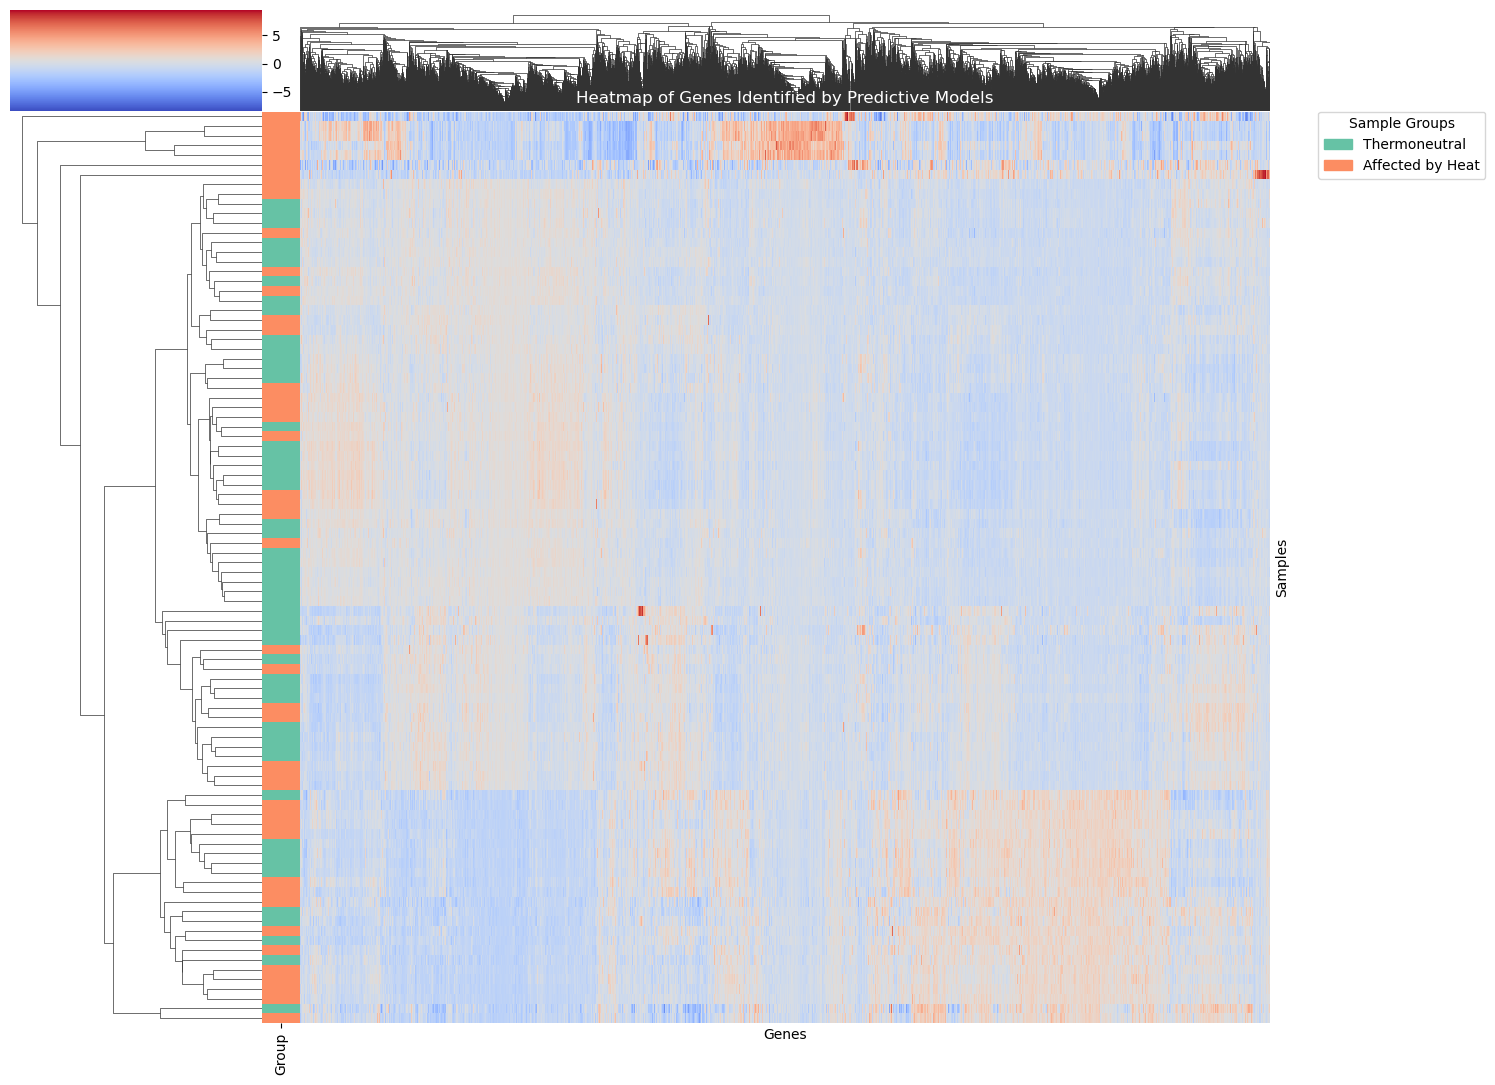

In [54]:
# Create the clustermap
g = sns.clustermap(
    expression_standardized,
    row_colors=group_colors,
    col_cluster=True,    # Cluster columns (genes)
    row_cluster=True,    # Cluster rows (samples)
    figsize=(15, 12),
    cmap='coolwarm',     # Choose a diverging colormap
    xticklabels=False,   # Optionally hide gene labels for clarity
    yticklabels=False,   # Optionally hide sample labels for clarity
    dendrogram_ratio=(0.2, 0.1),  # Adjust dendrogram sizes
    cbar_pos=(0.02, 0.8, 0.02, 0.18)  # Adjust colorbar position
)

# Adjust the position of the colorbar if necessary
g.cax.set_position([0.95, 0.2, 0.03, 0.45])  # [left, bottom, width, height]

# Create legend handles for sample groups
group_labels = sample_groups.unique()
group_handles = [mpatches.Patch(color=group_lut[label], label=label) for label in group_labels]

# Add legend to the heatmap
g.ax_heatmap.legend(
    handles=group_handles,
    labels=[handle.get_label() for handle in group_handles],
    title='Sample Groups',
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.,
    frameon=True
)

# Add axis labels and title
g.ax_heatmap.set_xlabel('Genes')
g.ax_heatmap.set_ylabel('Samples')
g.ax_heatmap.set_title('Heatmap of Genes Identified by Predictive Models', color='white')

# Adjust layout to prevent clipping of legend and labels
plt.subplots_adjust(right=0.85, top=0.9)

plt.show()


### 6. Write a short summary for each plot/table

1. Classification report from the Logistic regression Model summary:
The classification report shows the measured ability of the model's performance in predicting the clusters identified previously through hierarchical clustering. The report shows precision, recall, f1 score, and support for each cluster. The high accuracy shows that the model effectively predicts the clusters based on the gene data. Precision is the proportion of correctly predicted positive results among positive predictions, recall is the proportion of correctly predicted positive results among all actual positive results, f1 score is the mean of precision and recall, and support is the number of actual occurrences of each cluster in the data set. The first model’s report shows the results from the model trained on group distinction and the second shows the results from the model trained on cluster distinction.
ression.


2. Confusion matrix from the Logistic regression Model
The confusion matrix shows the model's predictions compared to the actual cluster results. Each cell in the matrix shows the count of samples where the predicted was different from the actual. Therefore having low numbers in the matrix shows effective predictive capabilities. The first matrix shows the results from the model trained on groups and shows a less effective model than the second one trained on clustering assignments. This is because the clusters are more defined compared to the groups that have some overlap.


3. Heatmap of Genes Identified by Predictive Models
The heatmap shows the expression level of genes identified by the predictive model with group categorization. The groups are labeled on the side showing clusters of the samples and genes. The color scale in the top left represents expression levels with blue being low expression and red being high expression.
